## Description

This notebook documents the perturbation analysis to test for robustness of 
Gromov-Wasserstein under various types of perturbations.

## Instructions

The first part of the notebook contains functionality to do perturbation 
analysis. We define a single experiment as making a consistent perturbation 
to a singular network. For example, we may choose to remove nodes one at a time 
according to some distribution (e.g. uniformly at random) from a network. 

For each experiment, there are generally three types 
of variables: 
1. the exact network we are operating over
2. the type of perturbation
3. the documented values for the experiment

For a sequence of experiments, which we define to be the SAME type of perturbation 
procedure over DIFFERENT networks (though these may come from the same generative 
models), we will track the variation in the documented values. 

From a sequence of experiments, we may also want to visualize them differently. 
However, we leave it to the user to dictate how their documented values are
transformed and visualized given the vast options available. 

In [1]:
import numpy as np
import networkx as nx
import got 
import ot 
import os 
import matplotlib.pyplot as plt
import random 

np.random.seed(123)
RESULTS_DIR = "results/perturbation"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

In [2]:
def perturbed_network(G: nx.DiGraph, perturber, documenter, stopper):
    """
    Performs a single set of perturbation analysis. 
    Inputs: 
    - G: the original graph before perturbation
    - perturber: a function that maps nx.DiGraph to nx.DiGraph. Essentially, 
      it takes in the graph at iteration t, returns the perturbed version 
      at iteration t. 
    - documenter: a function that takes in two nx.DiGraph and outputs the values 
      to compute in np.array form. 
    - stopper: a function that takes in an nx.DiGraph and determines whether 
      to stop the experiment (potentially due to impossibility of perturbing further)
    Output: 
    - a matrix of T x D documentations where T is the number of iterations, and 
      D is the total number of values to be documented.
    """ 
    G_origin = G.copy()
    G_iter = G.copy()
    res = None
    while not stopper(G_iter): 
        G_past = G_iter.copy()
        G_iter = perturber(G_iter)
        if res is None: 
            res = documenter(G_iter, G_past, G_origin)
        else: 
            res = np.vstack([res, documenter(G_iter, G_past, G_origin)])
    return res 


# Candidates for perturber function. 
def remove_edge_randomly(G): 
    "Removes an edge uniformly at random from the specified graph"
    G.remove_edge(*random.choice(list(G.edges())))
    return G.copy()

def remove_node_randomly(G): 
    "Removes a node uniformly at random from the specified graph"
    G.remove_node(random.choice(list(G.nodes())))
    return G.copy()

# Candidate for stopper function
def stop_if_no_nodes(G): 
    "Returns true if there are only one node left" 
    return len(list(G.nodes())) == 1

def stop_if_no_edges(G): 
    "Returns false if there are no edges left in a graph"
    return len(list(G.edges())) == 0

# Candidate for documenter functions 
def document_gw_diffs(G, G_past, G_origin): 
    """
    Returns an array that tracks GW_diff between current graph and origin, 
    as well as current graph and past graph. 
    """
    G_ot = got.GraphOT(G, "uniform")
    G_past_ot = got.GraphOT(G_past, "uniform")
    G_origin_ot = got.GraphOT(G_origin, "uniform")
    _, log = ot.gromov_wasserstein(G_ot.get_cost(), G_origin_ot.get_cost(), G_ot.get_node_dist(), G_origin_ot.get_node_dist(), log=True)
    gw_origin = log["gw_dist"]
    _, log = ot.gromov_wasserstein(G_ot.get_cost(), G_past_ot.get_cost(), G_ot.get_node_dist(), G_past_ot.get_node_dist(), log=True)
    gw_past = log["gw_dist"]
    return np.array([gw_origin, gw_past]).reshape((1, 2))

def perturbed_pipeline(Gs, perturber, documenter, stopper, duplicate = 0): 
    """
    A wrapper of perturbed network that concatenates all the data. 

    Inputs: Gs is a list of nx.DiGraph with the same number of nodes. 
            The rest of the parameters same as perturbed_network, and 
            are used only to call perturbed network. 
            The exception is duplicate, which is an integer that specifies 
            how many times to duplicate the experiment for each graph.
        
    Output: Array of [mean of GW distance to original graph, 
                      standard deviation of GW to original, 
                      mean of GW to prev graph, 
                      standard deviation of GW to prev]
    
    Note: The current implementation assumes that all experiments will 
          share the same number of perturbations! This ensures that 
          the sample size is consistent across the plot. 
    """
    if duplicate < 0:
        raise ValueError("Duplicate must be a non-negative integer.")
    
    if duplicate > 0:
        Gs = Gs * duplicate
        
    results = [perturbed_network(G_i, perturber, documenter, stopper) for G_i in Gs]
    max_len = max(len(res) for res in results)
    
    # We will pad the results to ensure they have the same length
    # and later we use the nanmean and nanstd to compute the mean and 
    # standard deviation while ignoring NaNs.
    n_graphs = len(Gs)
    padded_origin = np.full((n_graphs, max_len), np.nan)
    padded_past = np.full((n_graphs, max_len), np.nan)
    
    for i, res in enumerate(results):
        seq_len = len(res)
        padded_origin[i, :seq_len] = res[:, 0]
        padded_past[i, :seq_len] = res[:, 1]
    
    # Calculate statistics
    mean_origin = np.nanmean(padded_origin, axis=0)
    sd_origin = np.nanstd(padded_origin, axis=0, ddof=1)
    mean_past = np.nanmean(padded_past, axis=0)
    sd_past = np.nanstd(padded_past, axis=0, ddof=1)
    
    # Count valid samples at each iteration, so that we have access 
    # to the sample at each step of node removal if needed.
    sample_counts = np.sum(~np.isnan(padded_origin), axis=0)
    
    return [mean_origin, sd_origin, mean_past, sd_past, sample_counts]


# Synthetic Networks

In this section, we test our perturbation analysis (which consists of both node
and edge removal processes) on a well-known random graph model: Erdos-Renyi. 
The Erdos-Renyi graph admits one parameter p which takes value between 0 and 1 
inclusive. p is the probability of an edge existing between two nodes. 
So an Erdos-Renyi graph is sparse if p is low, and dense if p is high. 

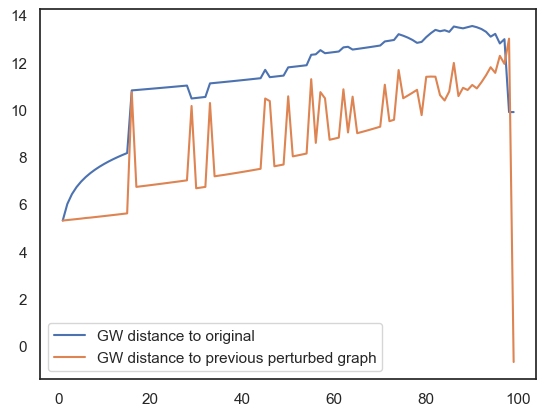

In [3]:
# Building a sparse Erdos-Renyi graph
G = nx.erdos_renyi_graph(n=100, p=0.05)
# Conducting the actual perturbation analysis
res = perturbed_network(G, remove_node_randomly, document_gw_diffs, stop_if_no_nodes)
# Visualizing the results in log-scale
epsilon = 0.0001
y_origin = np.log(res[:, 0] + epsilon)
y_past = np.log(res[:, 1] + epsilon)
x = np.arange(1, len(y_origin) + 1)
plt.plot(x, y_origin, label = "GW distance to original")
plt.plot(x, y_past, label = "GW distance to previous perturbed graph")
plt.legend()

Conduct a sanity test on a bunch of Erdos-Renyi graph using the perturbed 
pipeline code to verify that we are scaling up properly. The code below takes 
around 1-3 mins.

In [4]:
np.random.seed(5)
Gs = [nx.erdos_renyi_graph(n = 100, p = 0.05) for _ in range(30)]
res = perturbed_pipeline(Gs, remove_node_randomly, document_gw_diffs, stop_if_no_nodes)

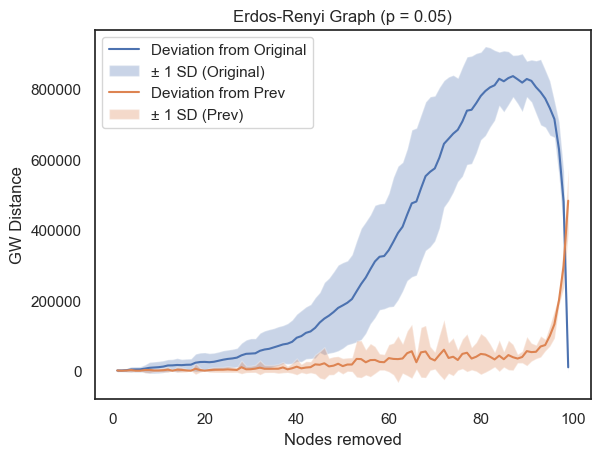

In [5]:
x = np.arange(1, len(res[0]) + 1)
plt.plot(x, res[0], label='Deviation from Original')
plt.fill_between(x, res[0] - res[1], res[0] + res[1], alpha=0.3, label='± 1 SD (Original)')
plt.plot(x, res[2], label='Deviation from Prev')
plt.fill_between(x, res[2] - res[3], res[2] + res[3], alpha=0.3, label='± 1 SD (Prev)')
plt.legend()
plt.xlabel("Nodes removed")
plt.ylabel("GW Distance")
plt.title("Erdos-Renyi Graph (p = 0.05)")
plt.savefig(f"{RESULTS_DIR}/erdos_renyi_p=0.05.png")